## Yield curve prediction

The goal of this case study is to use supervised learning-based models to predict the yield
curve. This case study is inspired by the paper “_Artificial Neural Networks in Fixed Income Markets for Yield Curve Forecasting_” by Nunes, Gerding, McGroarty and Niranj

## Content

* [1. Introduction](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
* [4. Data Preparation and analysis](#3)
    * [4.1.Feature Selection](#3.1)
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train/Test Split and Evaluation metrics](#4.1)]]
    * [5.3. Compare Models and Algorithms](#4.3)
* [6. Model Tuning and Grid Search](#5)
* [7. Finalize the Model](#6)  
    * [7.1. Results and comparison of Regression and MLP](#6.1)

<a id='0'></a>
# 1. Problem Definition

In the supervised regression framework used for this case study, three tenors (i.e. 1M,
5Y and 30Y) of the yield curve are the predicted variable. These tenors represent short
term, medium term and long-term tenors of the yield curve.

### Features

In order to make predictions, we use the following features: 


    1. Previous Changes in the Treasury Curve at the following tenors: 1 Month, 3 Month, 1 Year, 2 Year, 5 Year, 7 Year, 10 Year, 30 Year
        
    2. Changes in % of Federal Debt held by -
    
        a. Public,       
        b. Foreign Goverments        
        c. Federal Reserve
        
    3. The Coporate Spread on Baa rated Debt Relative to the 10 Year

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

### Feature Variables

In [21]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

# #Libraries for Deep Learning Models
# from keras.models import Sequential
# from keras.layers import Dense
# from tensorflow.keras.optimizers import SGD
# from keras.layers import LSTM
# from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

In [3]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='1.2'></a>
## 2.2. Loading the Data

In [7]:
# Get the data by webscapping using pandas datareader
tsy_tickers = ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30',
               'TREAST', # -- U.S. Treasury securities held by the Federal Reserve ( Millions of Dollars )
               'FYGFDPUN', # -- Federal Debt Held by the Public ( Millions of Dollars )
               'FDHBFIN', # -- Federal Debt Held by Foreign and International Investors ( Billions of Dollars )
               'GFDEBTN', # -- Federal Debt: Total Public Debt ( Millions of Dollars )
               'BAA10Y', # -- Baa Corporate Bond Yield Relative to Yield on 10-Year
              ]
tsy_data = web.DataReader(tsy_tickers, 'fred', start = '20100101', end = '20191231', ).dropna(how='all').ffill()
tsy_data['FDHBFIN'] = tsy_data['FDHBFIN'] * 1000
tsy_data['GOV_PCT'] = tsy_data['TREAST'] / tsy_data['GFDEBTN']
tsy_data['HOM_PCT'] = tsy_data['FYGFDPUN'] / tsy_data['GFDEBTN']
tsy_data['FOR_PCT'] = tsy_data['FDHBFIN'] / tsy_data['GFDEBTN']

In [8]:
return_period = 5
#Y = tsy_data.loc[:, ['DGS1MO', 'DGS5', 'DGS30']].diff(return_period).shift(-return_period)
#return_period = 5
Y = tsy_data.loc[:, ['DGS1MO', 'DGS5', 'DGS30']].shift(-return_period)
Y.columns = [col+'_pred' for col in Y.columns]

#X = tsy_data.loc[:, ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30', 'GOV_PCT', 'HOM_PCT', 'FOR_PCT', 'BAA10Y']].diff(return_period)
X = tsy_data.loc[:, ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30', 'GOV_PCT', 'HOM_PCT', 'FOR_PCT', 'BAA10Y']]

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.columns]
X = dataset.loc[:, X.columns]

In [9]:
Y

,DGS1MO_pred,DGS5_pred,DGS30_pred
DATE,,,
2010-01-06,0.02,2.55,4.71
2010-01-13,0.02,2.38,4.50
2010-01-21,0.01,2.41,4.57
2010-01-28,0.04,2.29,4.53
2010-02-04,0.05,2.39,4.69
...,...,...,...
2019-11-21,1.62,1.62,2.21
2019-11-29,1.52,1.67,2.29
2019-12-06,1.55,1.66,2.26


In [10]:
dataset.head()

,DGS1MO_pred,DGS5_pred,DGS30_pred,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
DATE,,,,,,,,,,,,,,,
2010-01-06,0.02,2.55,4.71,0.03,0.06,0.40,1.01,2.60,3.33,3.85,4.70,0.060799,0.649352,0.303598,2.49
2010-01-13,0.02,2.38,4.50,0.02,0.06,0.37,0.97,2.55,3.28,3.80,4.71,0.060800,0.649352,0.303598,2.50
2010-01-21,0.01,2.41,4.57,0.02,0.06,0.31,0.87,2.38,3.09,3.62,4.50,0.060800,0.649352,0.303598,2.51
2010-01-28,0.04,2.29,4.53,0.01,0.08,0.31,0.87,2.41,3.15,3.68,4.57,0.060801,0.649352,0.303598,2.57
2010-02-04,0.05,2.39,4.69,0.04,0.09,0.32,0.80,2.29,3.06,3.62,4.53,0.060801,0.649352,0.303598,2.62


In [7]:
dataset

,DGS1MO_pred,DGS5_pred,DGS30_pred,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
DATE,,,,,,,,,,,,,,,
2010-01-06,0.02,2.55,4.71,0.03,0.06,0.40,1.01,2.60,3.33,3.85,4.70,0.060799,0.649352,0.303598,2.49
2010-01-13,0.02,2.38,4.50,0.02,0.06,0.37,0.97,2.55,3.28,3.80,4.71,0.060800,0.649352,0.303598,2.50
2010-01-21,0.01,2.41,4.57,0.02,0.06,0.31,0.87,2.38,3.09,3.62,4.50,0.060800,0.649352,0.303598,2.51
2010-01-28,0.04,2.29,4.53,0.01,0.08,0.31,0.87,2.41,3.15,3.68,4.57,0.060801,0.649352,0.303598,2.57
2010-02-04,0.05,2.39,4.69,0.04,0.09,0.32,0.80,2.29,3.06,3.62,4.53,0.060801,0.649352,0.303598,2.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-21,1.62,1.62,2.21,1.57,1.58,1.55,1.60,1.62,1.71,1.77,2.24,0.095700,0.740792,0.294991,2.15
2019-11-29,1.52,1.67,2.29,1.62,1.59,1.60,1.61,1.62,1.73,1.78,2.21,0.096912,0.740792,0.294991,2.08
2019-12-06,1.55,1.66,2.26,1.52,1.53,1.57,1.61,1.67,1.78,1.84,2.29,0.097402,0.740792,0.294991,2.07


<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [11]:
dataset.shape

(504, 15)

In [13]:

dataset.describe()

,DGS1MO_pred,DGS5_pred,DGS30_pred,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
count,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000
mean,0.541905,1.644444,3.181647,0.538869,0.575853,0.744127,0.959603,1.646270,2.041905,2.401071,3.186369,0.110283,0.711243,0.320017,2.589167
std,0.779359,0.593743,0.611170,0.778365,0.796082,0.809826,0.750459,0.595265,0.558321,0.553351,0.613689,0.021603,0.023164,0.017531,0.450373
min,0.000000,0.570000,1.950000,0.000000,0.000000,0.090000,0.180000,0.570000,0.930000,1.400000,1.950000,0.057293,0.649352,0.285341,1.580000
25%,0.030000,1.250000,2.807500,0.030000,0.047500,0.160000,0.370000,1.250000,1.600000,1.960000,2.810000,0.100817,0.700537,0.304740,2.240000
50%,0.115000,1.620000,3.045000,0.110000,0.130000,0.295000,0.680000,1.620000,2.050000,2.345000,3.050000,0.112621,0.719631,0.324393,2.600000
75%,0.875000,1.962500,3.450000,0.842500,0.992500,1.220000,1.330000,1.970000,2.372500,2.762500,3.452500,0.126549,0.724297,0.337660,2.900000
max,2.450000,3.070000,4.810000,2.450000,2.480000,2.740000,2.960000,3.070000,3.400000,3.960000,4.810000,0.137377,0.740792,0.341355,3.600000


<a id='2.2'></a>
## 3.2. Data Visualization

<AxesSubplot:xlabel='DATE'>

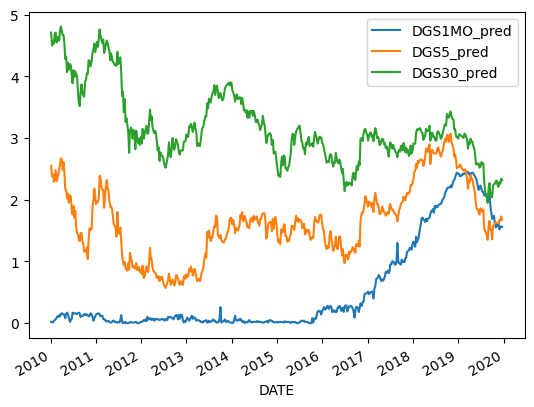

In [14]:
Y.plot()

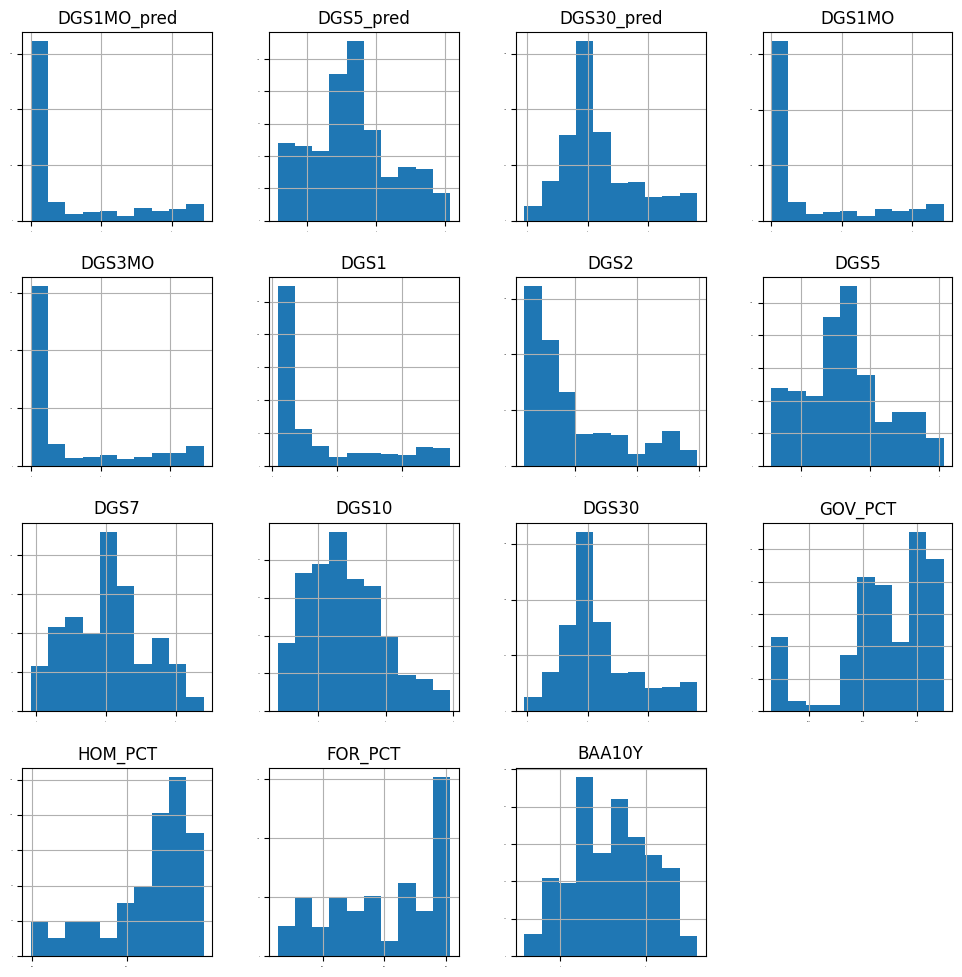

In [15]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

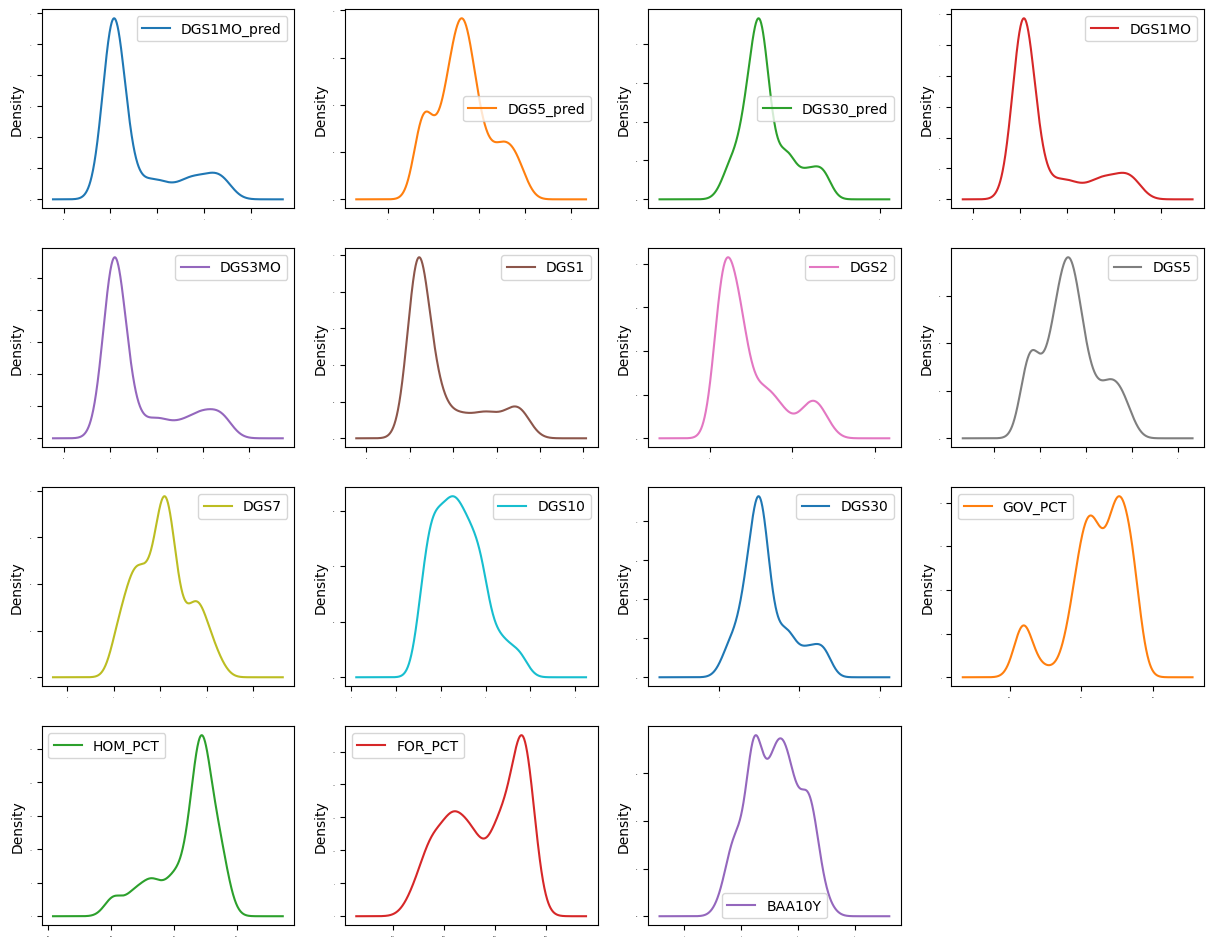

In [16]:
# density
dataset.plot(
    kind='density', subplots=True, layout=(5,4), 
    sharex=False, legend=True, fontsize=1, figsize=(15,15)
)
pyplot.show()

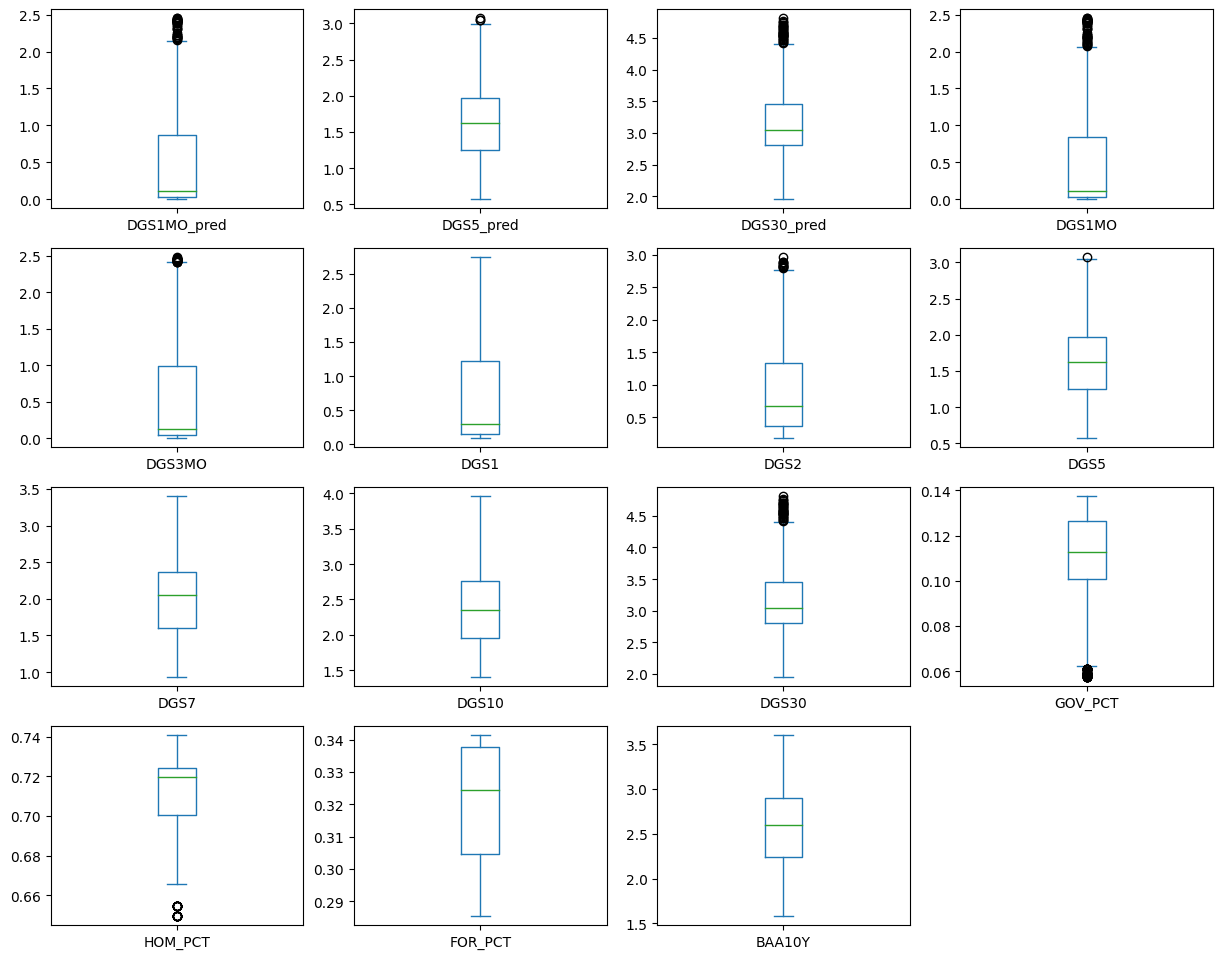

In [17]:
#Box and Whisker Plots
dataset.plot(kind='box', subplots=True, layout=(5,4), sharex=False, sharey=False, figsize=(15,15))
pyplot.show()

Next We look at the interaction between these variables.

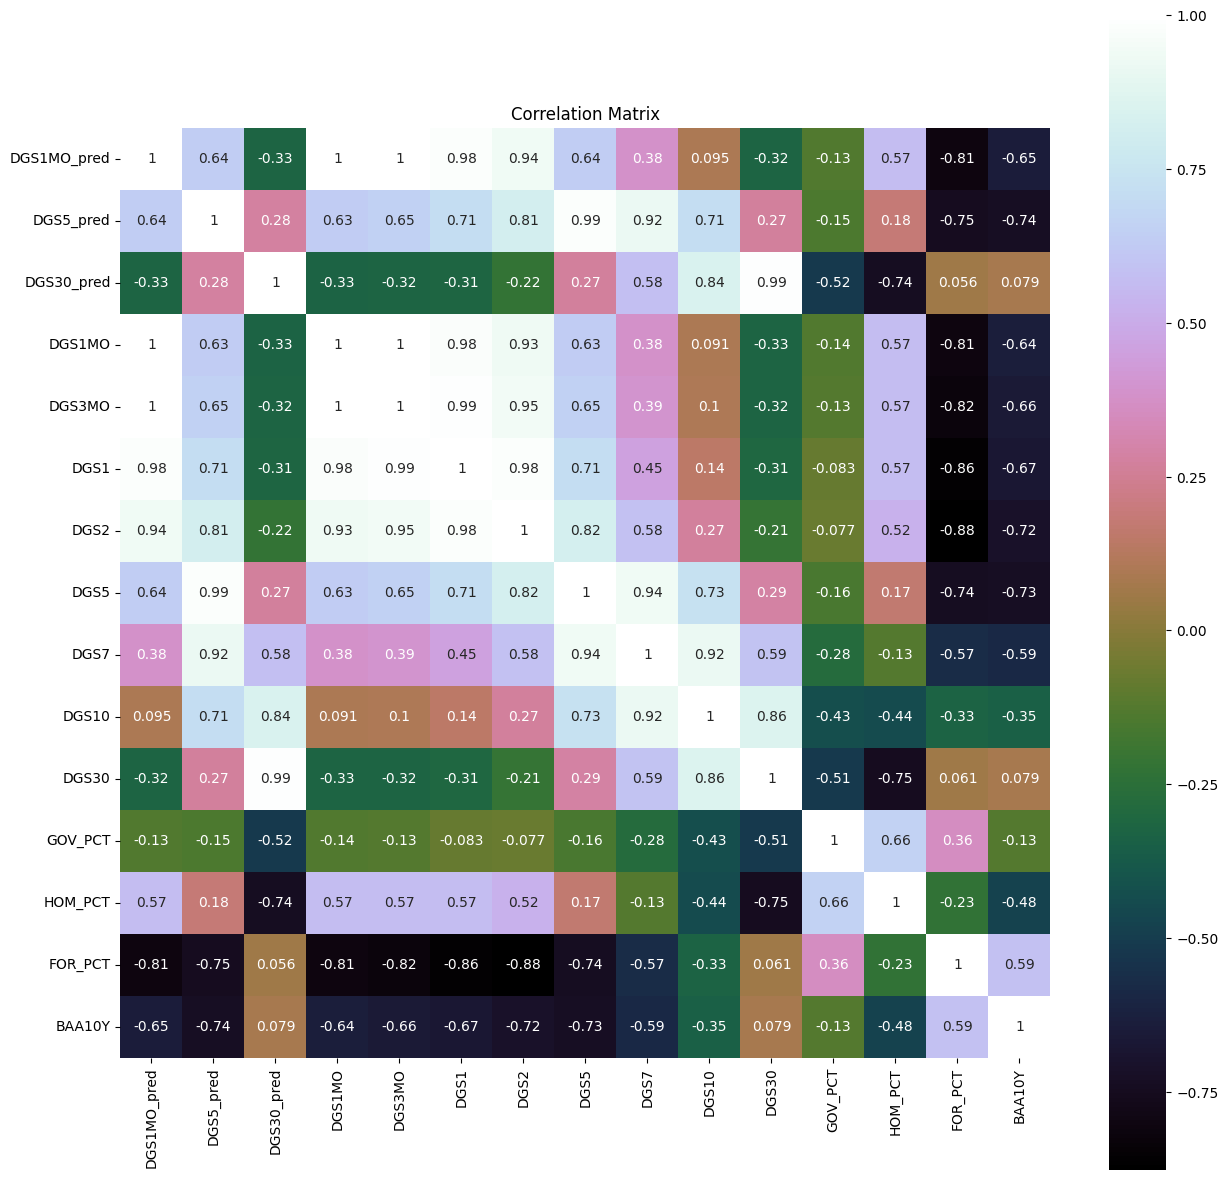

In [18]:
# correlation
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')
pyplot.show()

Form the correlation plot, we see that the 1 month and the 30 year yield data points are negatively autocorrelated. The 5 year yield also seems to be negativly correlated with the changes in foreign goverment purchases.

<Figure size 1500x1500 with 0 Axes>

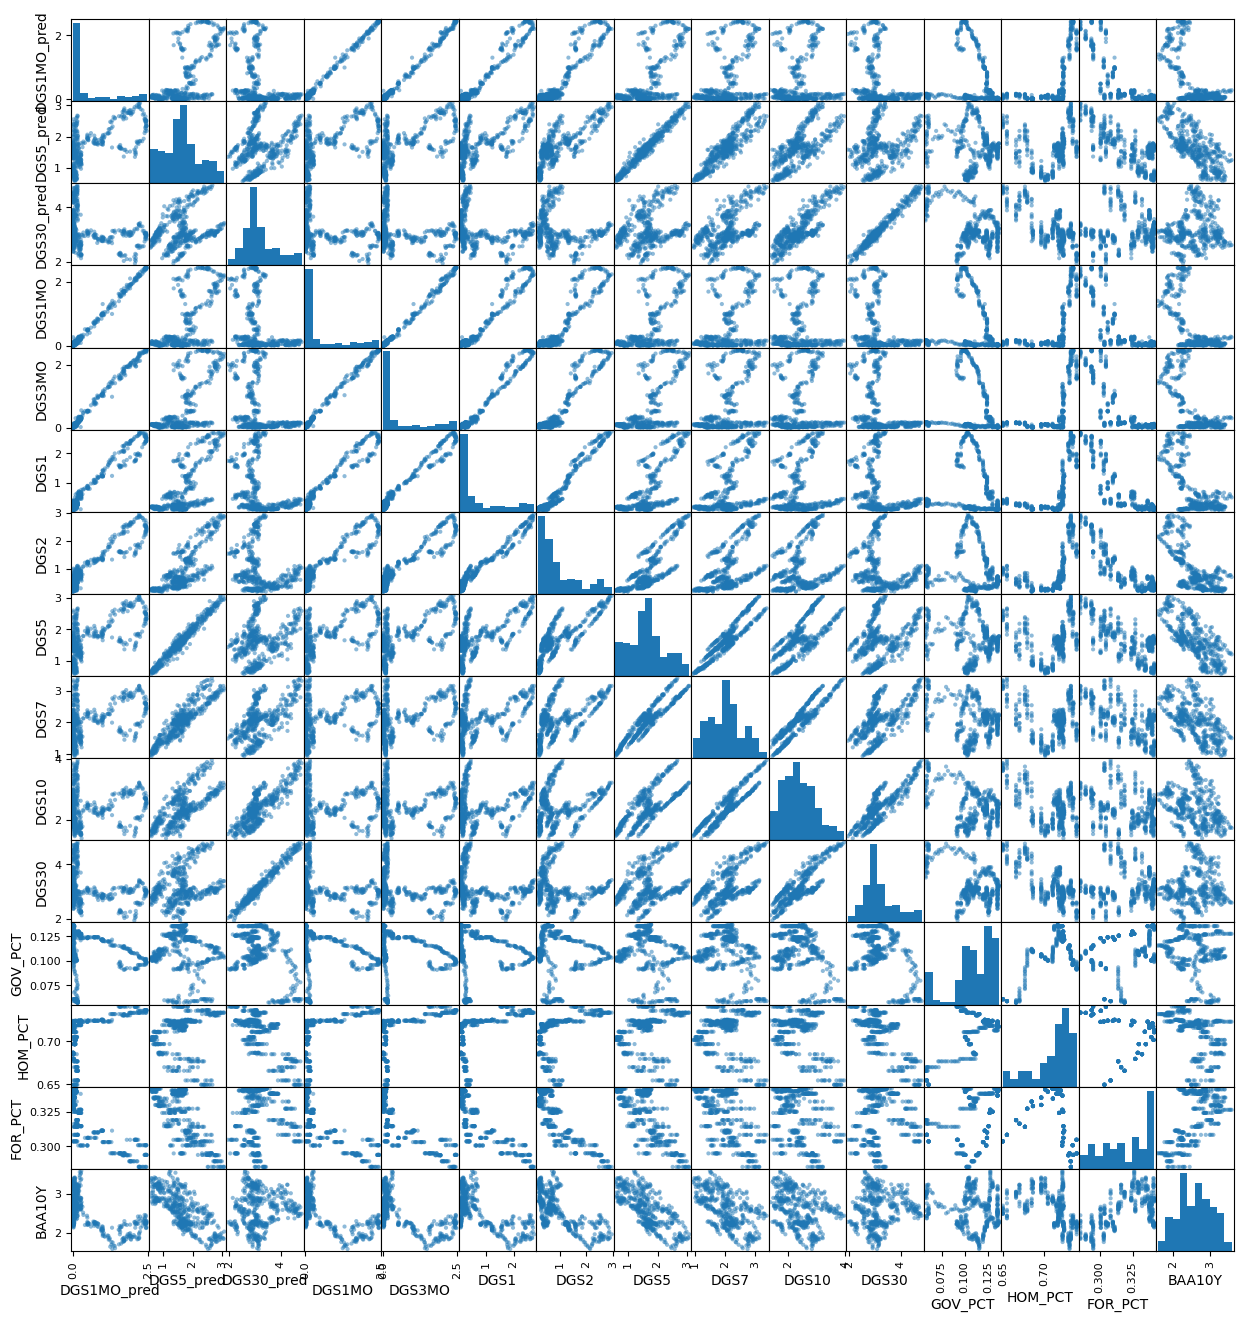

In [19]:
# Scatterplot Matrix
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(15,16))
pyplot.show()

We see significant linear relationship of the predicted variables with their lags and other tenors of the yield curve. There is also a linear relationship, with negative slope between 1M, 5Y rates versus corporate spread and changes in foreign government purchases. Overall, we see a lot of linear relationship, and we expect the linear models to perform well.

<a id='2.3'></a>
## 3.3. Time Series Analysis

#### 1 Month

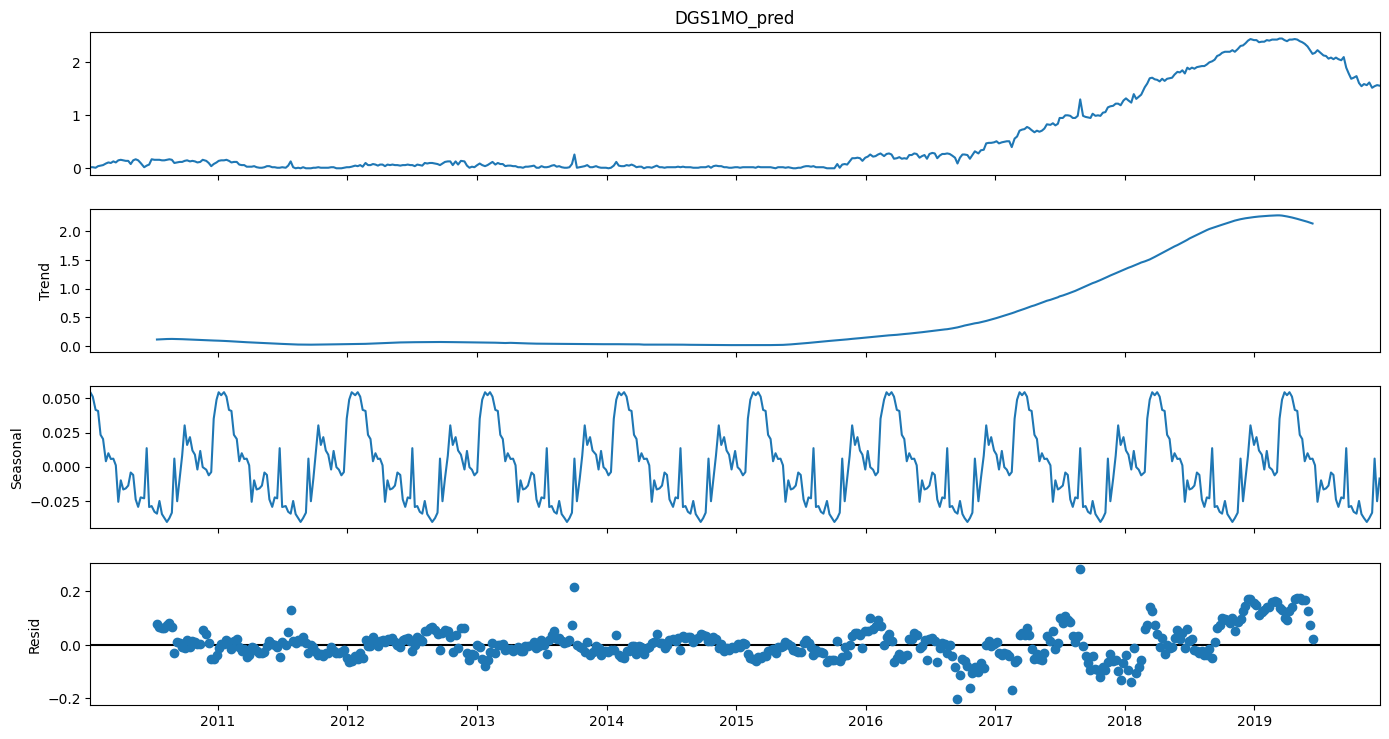

In [25]:
temp_Y = dataset['DGS1MO_pred']
res = sm.tsa.seasonal_decompose(temp_Y, period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

#### 5 Year

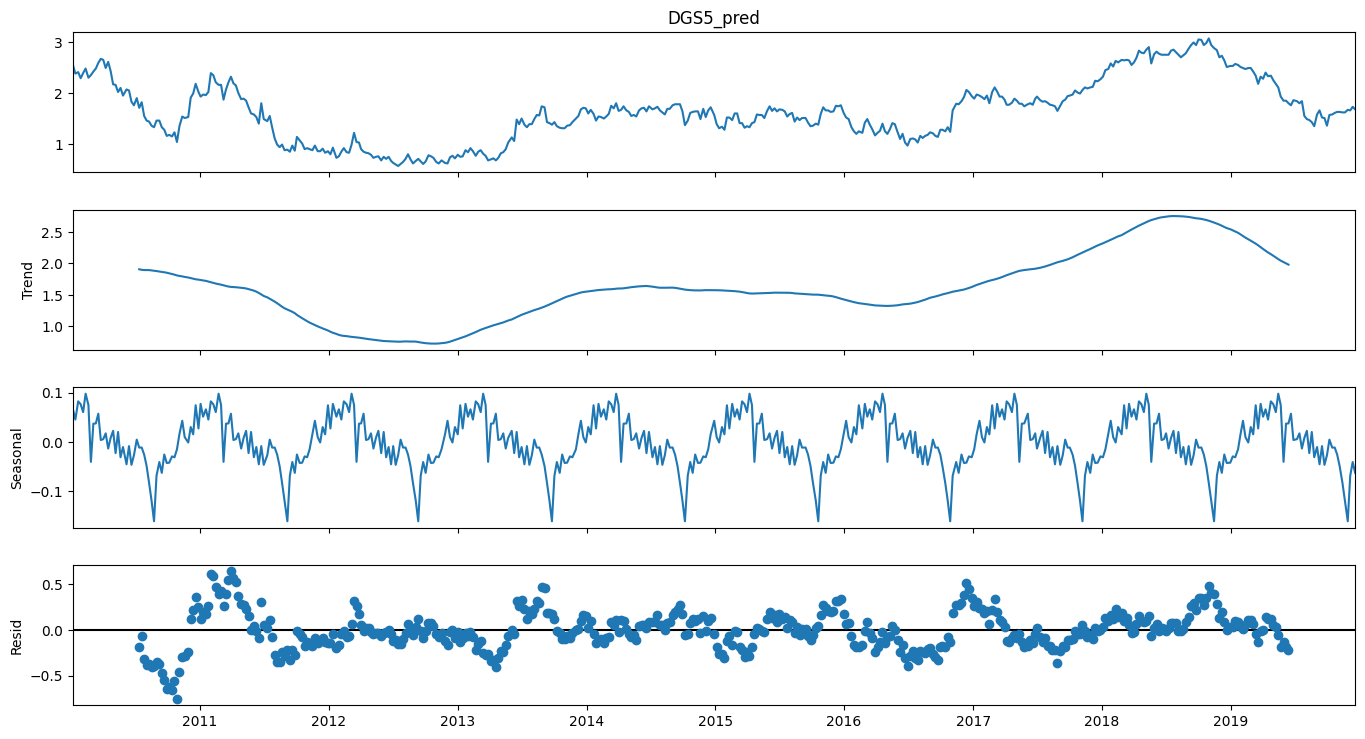

In [26]:
temp_Y = dataset['DGS5_pred']
res = sm.tsa.seasonal_decompose(temp_Y,period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

#### 30 Year

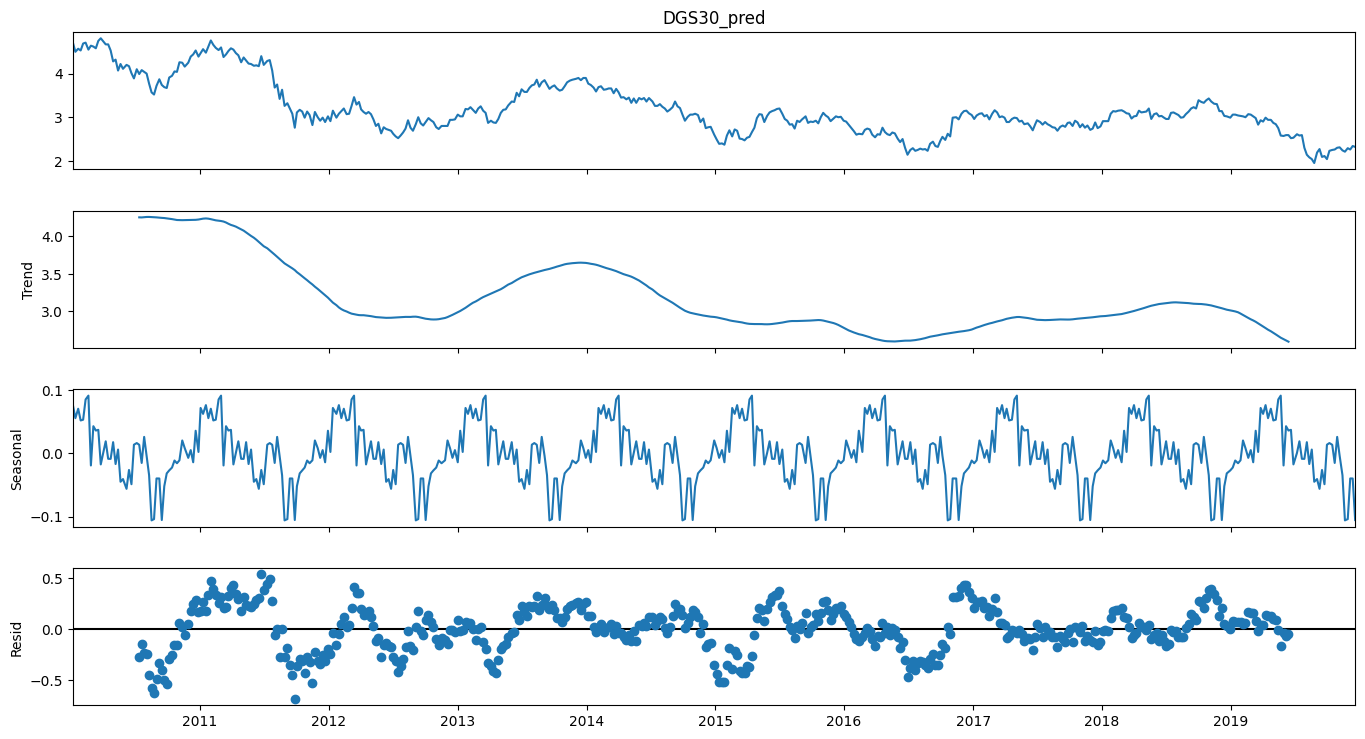

In [27]:
temp_Y = dataset['DGS30_pred']
res = sm.tsa.seasonal_decompose(temp_Y,period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

Around Q1 2018, we observe a trend decrease in the 1 Month, 5 year and 30 year. However, the trend is most pronounced in the 1 month series.

<a id='3'></a>
## 4. Data Preparation and analysis

<a id='3.1'></a>
## 4.1. Univariate Feature Selection

In [19]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
for col in Y.columns:
    temp_Y = dataset[col]
    temp_X = dataset.loc[:, X.columns]
    fit = bestfeatures.fit(temp_X,temp_Y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    print(col)
    print(featureScores.nlargest(10,'Score'))  #print 10 best features
    print('--------------')

DGS1MO_pred
      Specs       Score
0    DGS1MO  152439.908
1    DGS3MO  100295.080
2      DGS1   11167.924
3      DGS2    3504.919
10  FOR_PCT     956.164
11   BAA10Y     358.381
4      DGS5     343.804
9   HOM_PCT     241.461
5      DGS7      85.943
7     DGS30      58.712
--------------
DGS5_pred
      Specs      Score
4      DGS5  16556.415
5      DGS7   2719.264
3      DGS2    974.020
10  FOR_PCT    629.036
11   BAA10Y    591.248
6     DGS10    517.782
2      DGS1    506.494
1    DGS3MO    364.670
0    DGS1MO    328.479
7     DGS30     39.453
--------------
DGS30_pred
     Specs      Score
7    DGS30  17012.132
6    DGS10   1231.019
9  HOM_PCT    625.166
5     DGS7    251.664
8  GOV_PCT    181.667
0   DGS1MO     60.893
1   DGS3MO     59.270
2     DGS1     54.492
4     DGS5     40.600
3     DGS2     25.317
--------------


As expected, based on the univariate feature selection, all the time series are most dependent on the previous changes.

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split and evaluation metrics

In [20]:
# split out validation dataset for the end

validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

We use the prebuilt scikit models to run a K fold analysis on our training data. We then train the model on the full training data and use it for prediction of the test data. The parameters for the K fold analysis are defined as -

In [21]:
# test options for regression
num_folds = 10
scoring = 'neg_mean_squared_error'

<a id='4.2'></a>
## 5.2. Compare Models and Algorithms

In [609]:
# spot check the algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
#Neural Network
models.append(('MLP', MLPRegressor()))

In [610]:
kfold_results = []
names = []
validation_results = []
train_results = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    names.append(name)

    # Finally we Train on the full period and test against validation
    res = model.fit(X_train, Y_train)
    validation_result = np.mean(np.square(res.predict(X_validation) - Y_validation))
    validation_results.append(validation_result)
    train_result = np.mean(np.square(res.predict(X_train) - Y_train))
    train_results.append(train_result)
    
    msg = "%s: \nAverage CV error: %s \nStd CV Error: (%s) \nTraining Error:\n%s \nTest Error:\n%s" % \
    (name, str(cv_results.mean()), str(cv_results.std()), str(train_result), str(validation_result))
    print(msg)
    print('----------')

LR: 
Average CV error: 0.007942891864184351 
Std CV Error: (0.002627539557566172) 
Training Error:
DGS1MO_pred    0.002
DGS5_pred      0.010
DGS30_pred     0.010
dtype: float64 
Test Error:
DGS1MO_pred    0.001
DGS5_pred      0.009
DGS30_pred     0.010
dtype: float64
----------
LASSO: 
Average CV error: 0.44035581436209686 
Std CV Error: (0.05366688435468398) 
Training Error:
DGS1MO_pred    0.574
DGS5_pred      0.352
DGS30_pred     0.388
dtype: float64 
Test Error:
DGS1MO_pred    0.743
DGS5_pred      0.350
DGS30_pred     0.318
dtype: float64
----------
EN: 
Average CV error: 0.4019832745740823 
Std CV Error: (0.050762635401215755) 
Training Error:
DGS1MO_pred    0.455
DGS5_pred      0.352
DGS30_pred     0.388
dtype: float64 
Test Error:
DGS1MO_pred    0.592
DGS5_pred      0.350
DGS30_pred     0.318
dtype: float64
----------
KNN: 
Average CV error: 0.009184607723577237 
Std CV Error: (0.003118097916218511) 
Training Error:
DGS1MO_pred    0.002
DGS5_pred      0.008
DGS30_pred     0.007
d

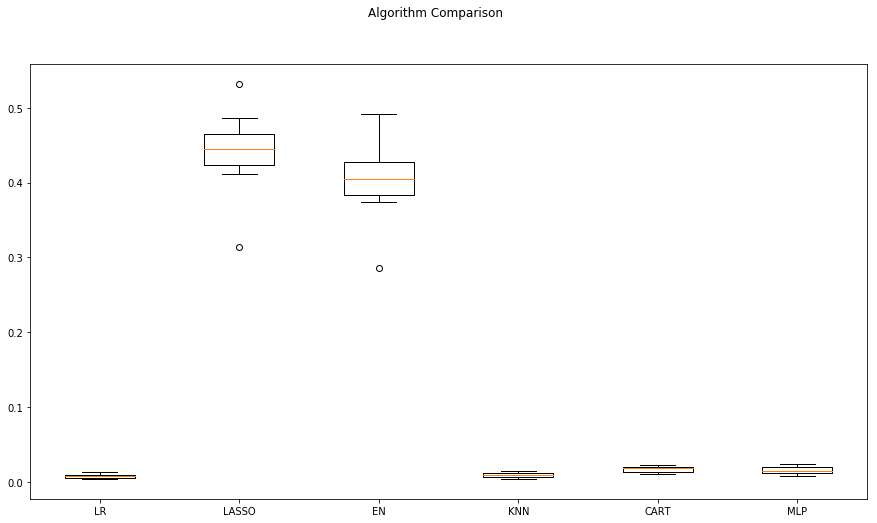

In [611]:
# compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

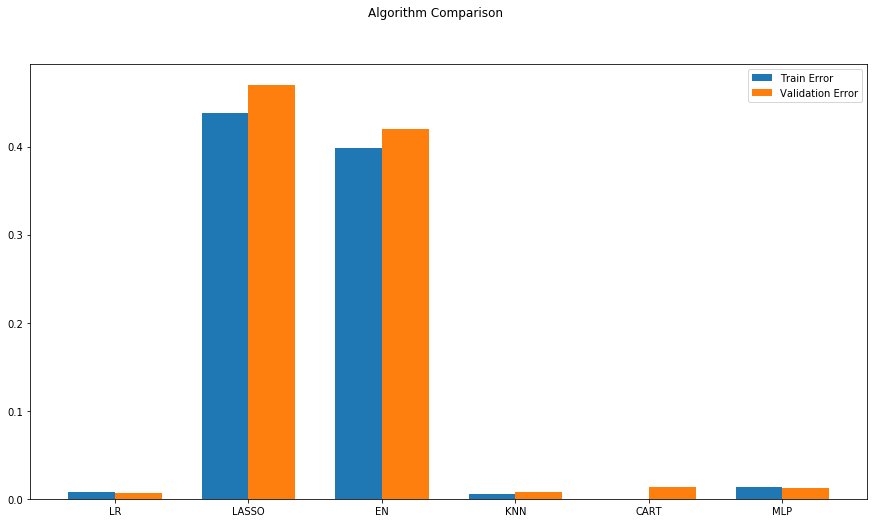

In [612]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, [x.mean() for x in train_results],  width=width, label='Train Error')
pyplot.bar(ind + width/2, [x.mean() for x in validation_results], width=width, label='Validation Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

<a id='5'></a>
# 6. Model Tuning and Grid Search

In [613]:
# 7. Grid search : MLPRegressor 
'''
hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
    The ith element represents the number of neurons in the ith
    hidden layer.
'''
param_grid={'hidden_layer_sizes': [(20,), (50,), (20,20), (20, 30, 20)]}
model = MLPRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.018006 using {'hidden_layer_sizes': (20, 30, 20)}
-0.036433 (0.019326) with: {'hidden_layer_sizes': (20,)}
-0.020793 (0.007075) with: {'hidden_layer_sizes': (50,)}
-0.026638 (0.010154) with: {'hidden_layer_sizes': (20, 20)}
-0.018006 (0.005637) with: {'hidden_layer_sizes': (20, 30, 20)}


<a id='6'></a>
# 7. Finalise the Model

In [26]:
# prepare model
model = MLPRegressor(hidden_layer_sizes= (20, 30, 20))
model.fit(X_train, Y_train)

MLPRegressor(hidden_layer_sizes=(20, 30, 20))

<a id='6.1'></a>
## 7.1. Results and comparison of Regression and MLP

In [27]:
# estimate accuracy on validation set
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
predictions = model.predict(X_validation)
mse_MLP = mean_squared_error(Y_validation, predictions)
r2_MLP = r2_score(Y_validation, predictions)

# prepare model
model_2 = LinearRegression()
model_2.fit(X_train, Y_train)
predictions_2 = model_2.predict(X_validation)

mse_OLS = mean_squared_error(Y_validation, predictions_2)
r2_OLS = r2_score(Y_validation, predictions_2)
print("MSE Regression = %f, MSE MLP = %f" % (mse_OLS, mse_MLP ))
print("R2 Regression = %f, R2 MLP = %f" % (r2_OLS, r2_MLP ))


MSE Regression = 0.006778, MSE MLP = 0.011791
R2 Regression = 0.979827, R2 MLP = 0.965583


The statistics of MLP and Linear regression are comparable. Let us check the prediction shape on the validation set. 

### Predictions - 5 Year - MLP

In [616]:
train_size = int(len(X) * (1-validation_size))
X_train, X_validation = X[0:train_size], X[train_size:len(X)]
Y_train, Y_validation = Y[0:train_size], Y[train_size:len(X)]

modelMLP = MLPRegressor(hidden_layer_sizes= (50,))
modelOLS = LinearRegression()
model_MLP = modelMLP.fit(X_train, Y_train)
model_OLS = modelOLS.fit(X_train, Y_train)

Y_predMLP = pd.DataFrame(model_MLP.predict(X_validation), index=Y_validation.index,
                      columns=Y_validation.columns)

Y_predOLS = pd.DataFrame(model_OLS.predict(X_validation), index=Y_validation.index,
                      columns=Y_validation.columns)


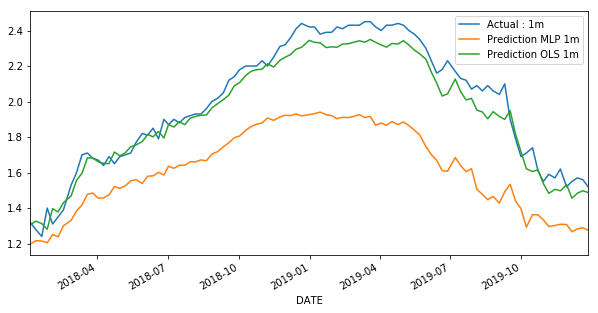

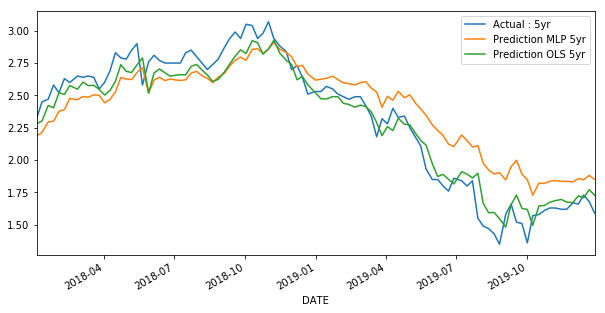

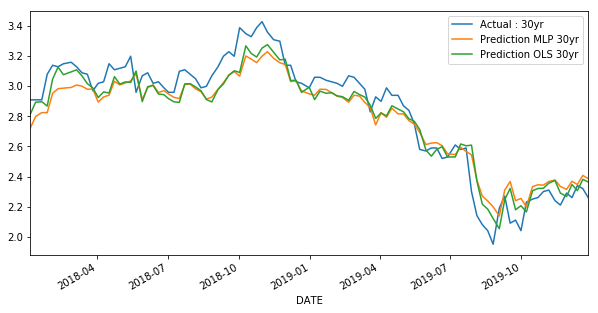

In [617]:
pd.DataFrame({'Actual : 1m': Y_validation.loc[:, 'DGS1MO_pred'],
              'Prediction MLP 1m': Y_predMLP.loc[:, 'DGS1MO_pred'],
              'Prediction OLS 1m': Y_predOLS.loc[:, 'DGS1MO_pred']}).plot(figsize=(10,5))

pd.DataFrame({'Actual : 5yr': Y_validation.loc[:, 'DGS5_pred'],
              'Prediction MLP 5yr': Y_predMLP.loc[:, 'DGS5_pred'],
              'Prediction OLS 5yr': Y_predOLS.loc[:, 'DGS5_pred']}).plot(figsize=(10,5))

pd.DataFrame({'Actual : 30yr': Y_validation.loc[:, 'DGS30_pred'],
              'Prediction MLP 30yr': Y_predMLP.loc[:, 'DGS30_pred'],
              'Prediction OLS 30yr': Y_predOLS.loc[:, 'DGS30_pred']}).plot(figsize=(10,5))



Overall, the regression and MLP are comparable, however, for 1m tenor, the fitting with MLP is slighly poor as compared to the regression. However,the multitask learning with neural network is more intuitive for modeling many time series simultaneousl 

### Summary

The linear regression model, despite its simplicity, is a tough benchmark to beat for such one step ahead forecasting, given the dominant characteristic of the last available value of the variable to predict. The ANN results in this case study are comparable to the linear regression models.

The good thing about ANN is that it is more flexible to changing market conditions. Also, ANN models can be enhanced by performing grid search on several other hyperparameters and using recurrent neural network such as LSTM.